In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import ttest_ind, pearsonr
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🚀 Starting Trader Performance vs Market Sentiment Analysis")
print("="*60)

from google.colab import drive
drive.mount('/content/drive')

#Error Handling
try:
    sentiment_df = pd.read_csv('/content/drive/MyDrive/fear_greed_index.csv')
    traders_df = pd.read_csv('/content/drive/MyDrive/historical_data.csv')
    print(f"✅ Data loaded successfully")
    print(f"   Sentiment data: {sentiment_df.shape[0]} rows")
    print(f"   Trading data: {traders_df.shape[0]} rows")
except FileNotFoundError as e:
    print(f"❌ Error loading files: {e}")
    exit()

print("\n📊 Data Quality Assessment:")
print(f"Trading data missing values:\n{traders_df.isnull().sum()}")
print(f"\nSentiment data missing values:\n{sentiment_df.isnull().sum()}")

🚀 Starting Trader Performance vs Market Sentiment Analysis
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Data loaded successfully
   Sentiment data: 2644 rows
   Trading data: 211224 rows

📊 Data Quality Assessment:
Trading data missing values:
Account             0
Coin                0
Execution Price     0
Size Tokens         0
Size USD            0
Side                0
Timestamp IST       0
Start Position      0
Direction           0
Closed PnL          0
Transaction Hash    0
Order ID            0
Crossed             0
Fee                 0
Trade ID            0
Timestamp           0
dtype: int64

Sentiment data missing values:
timestamp         0
value             0
classification    0
date              0
dtype: int64


In [3]:
def parse_dates_flexible(df, date_col):
    """Flexible date parsing function"""
    formats = ["%d-%m-%Y %H:%M", "%Y-%m-%d %H:%M:%S", "%Y-%m-%d", "%d/%m/%Y"]
    for fmt in formats:
        try:
            return pd.to_datetime(df[date_col], format=fmt, errors='coerce')
        except:
            continue
    return pd.to_datetime(df[date_col], errors='coerce')

#Parse dates
traders_df['Timestamp'] = parse_dates_flexible(traders_df, 'Timestamp IST')
traders_df['Date'] = traders_df['Timestamp'].dt.normalize()
sentiment_df['Date'] = pd.to_datetime(sentiment_df['date']).dt.normalize()

# Remove invalid dates
traders_df = traders_df.dropna(subset=['Timestamp'])
sentiment_df = sentiment_df.dropna(subset=['Date'])

print(f"✅ Date range - Trading: {traders_df['Date'].min()} to {traders_df['Date'].max()}")
print(f"✅ Date range - Sentiment: {sentiment_df['Date'].min()} to {sentiment_df['Date'].max()}")

✅ Date range - Trading: 2023-05-01 00:00:00 to 2025-05-01 00:00:00
✅ Date range - Sentiment: 2018-02-01 00:00:00 to 2025-05-02 00:00:00


In [4]:
#Merge with Overlap Analysis
merged_df = pd.merge(traders_df, sentiment_df, on='Date', how='inner')
print(f"\n🔗 Merged dataset: {merged_df.shape[0]} records across {merged_df['Date'].nunique()} unique dates")

if merged_df.empty:
    print("❌ No overlapping dates found. Check date formats and ranges.")
    exit()


🔗 Merged dataset: 211218 records across 479 unique dates


In [5]:
# Feature Engineering
def create_features(df):
    """Create additional trading and sentiment features"""
    df = df.copy()

    # Trading features
    df['hour'] = df['Timestamp'].dt.hour
    df['day_of_week'] = df['Timestamp'].dt.dayofweek
    df['trade_intensity'] = df['Size USD'] / df['Execution Price']

    # Sentiment categories
    df['sentiment_category'] = pd.cut(df['value'],
                                    bins=[0, 25, 45, 55, 75, 100],
                                    labels=['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed'])

    return df

merged_df = create_features(merged_df)

In [6]:
# Comprehensive Daily Aggregation
daily_summary = merged_df.groupby('Date').agg({
    'Size USD': ['sum', 'mean', 'std', 'count'],
    'Execution Price': ['mean', 'std', 'min', 'max'],
    'value': ['mean', 'std'],
    'trade_intensity': ['mean', 'sum']
}).reset_index()

daily_summary.columns = ['Date'] + ['_'.join(col).strip() for col in daily_summary.columns[1:]]

In [7]:
# Enhanced Lag Features
for lag in [1, 2, 3, 7]:  # 1, 2, 3 days and 1 week
    daily_summary[f'sentiment_lag{lag}'] = daily_summary['value_mean'].shift(lag)
    daily_summary[f'volume_lag{lag}'] = daily_summary['Size USD_sum'].shift(lag)

daily_summary = daily_summary.dropna()
print(f"📈 Daily summary created: {daily_summary.shape[0]} trading days")

📈 Daily summary created: 466 trading days


In [8]:
# Statistical Analysis Suite
def comprehensive_statistical_analysis(df):
    """Perform comprehensive statistical analysis"""

    print("\n" + "="*50)
    print("📊 COMPREHENSIVE STATISTICAL ANALYSIS")
    print("="*50)

    # 1. Sentiment Distribution Analysis
    sentiment_stats = df.groupby('classification')['Size USD'].agg(['count', 'mean', 'std', 'median'])
    print("\n1️⃣ Trade Size by Sentiment Classification:")
    print(sentiment_stats)

    # 2. Enhanced T-Tests
    fear_trades = df[df['classification'].str.lower() == 'fear']['Size USD'].dropna()
    greed_trades = df[df['classification'].str.lower() == 'greed']['Size USD'].dropna()

    if len(fear_trades) > 0 and len(greed_trades) > 0:
        t_stat, p_value = ttest_ind(fear_trades, greed_trades, equal_var=False)
        print(f"\n2️⃣ T-test (Fear vs Greed Trade Sizes):")
        print(f"   t-statistic: {t_stat:.4f}")
        print(f"   p-value: {p_value:.6f}")
        print(f"   Significance: {'Significant' if p_value < 0.05 else 'Not Significant'}")

        # Effect size (Cohen's d)
        pooled_std = np.sqrt(((len(fear_trades)-1)*fear_trades.var() + (len(greed_trades)-1)*greed_trades.var()) /
                           (len(fear_trades) + len(greed_trades) - 2))
        cohens_d = (greed_trades.mean() - fear_trades.mean()) / pooled_std
        print(f"   Effect Size (Cohen's d): {cohens_d:.4f}")

    # 3. Correlation Analysis
    print(f"\n3️⃣ Correlation Analysis:")
    corr_vars = ['value', 'Size USD', 'Execution Price', 'trade_intensity']
    available_vars = [var for var in corr_vars if var in df.columns]

    if len(available_vars) > 1:
        corr_matrix = df[available_vars].corr()
        print("Correlation Matrix:")
        print(corr_matrix.round(4))

    return sentiment_stats

sentiment_analysis = comprehensive_statistical_analysis(merged_df)



📊 COMPREHENSIVE STATISTICAL ANALYSIS

1️⃣ Trade Size by Sentiment Classification:
                count         mean           std   median
classification                                           
Extreme Fear    21400  5349.731843  22306.826180  766.150
Extreme Greed   39992  3112.251565  11061.998403  500.050
Fear            61837  7816.109931  51914.859249  735.960
Greed           50303  5736.884375  30533.418602  555.000
Neutral         37686  4782.732661  37461.883466  547.655

2️⃣ T-test (Fear vs Greed Trade Sizes):
   t-statistic: 8.3424
   p-value: 0.000000
   Significance: Significant
   Effect Size (Cohen's d): -0.0476

3️⃣ Correlation Analysis:
Correlation Matrix:
                  value  Size USD  Execution Price  trade_intensity
value            1.0000   -0.0298          -0.0276           0.0231
Size USD        -0.0298    1.0000           0.1899           0.0133
Execution Price -0.0276    0.1899           1.0000          -0.0172
trade_intensity  0.0231    0.0133         

In [9]:
#  Advanced Modeling Suite
def advanced_modeling_suite(daily_data):
    """Advanced modeling with multiple algorithms"""

    print("\n" + "="*50)
    print("🤖 ADVANCED PREDICTIVE MODELING")
    print("="*50)

    # Prepare features
    feature_cols = [col for col in daily_data.columns if 'lag' in col and not daily_data[col].isnull().all()]

    if len(feature_cols) < 2:
        print("❌ Insufficient lag features for modeling")
        return None

    X = daily_data[feature_cols].dropna()
    y = daily_data.loc[X.index, 'Execution Price_mean']

    if len(X) < 10:
        print("❌ Insufficient data points for modeling")
        return None

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42)
    }

    results = {}

    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        results[name] = {'model': model, 'rmse': rmse, 'r2': r2, 'predictions': y_pred}

        print(f"\n{name} Results:")
        print(f"   RMSE: {rmse:.4f}")
        print(f"   R²: {r2:.4f}")

        # Feature importance for Random Forest
        if name == 'Random Forest' and hasattr(model, 'feature_importances_'):
            importance_df = pd.DataFrame({
                'feature': feature_cols,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            print(f"   Top 3 Features:")
            for _, row in importance_df.head(3).iterrows():
                print(f"     {row['feature']}: {row['importance']:.4f}")

    return results, X_test, y_test

modeling_results = advanced_modeling_suite(daily_summary)


🤖 ADVANCED PREDICTIVE MODELING

Linear Regression Results:
   RMSE: 14690.9468
   R²: -0.1349

Random Forest Results:
   RMSE: 14240.2890
   R²: -0.0663
   Top 3 Features:
     volume_lag3: 0.1840
     volume_lag1: 0.1496
     volume_lag7: 0.1465



📈 Generating Comprehensive Visualizations...


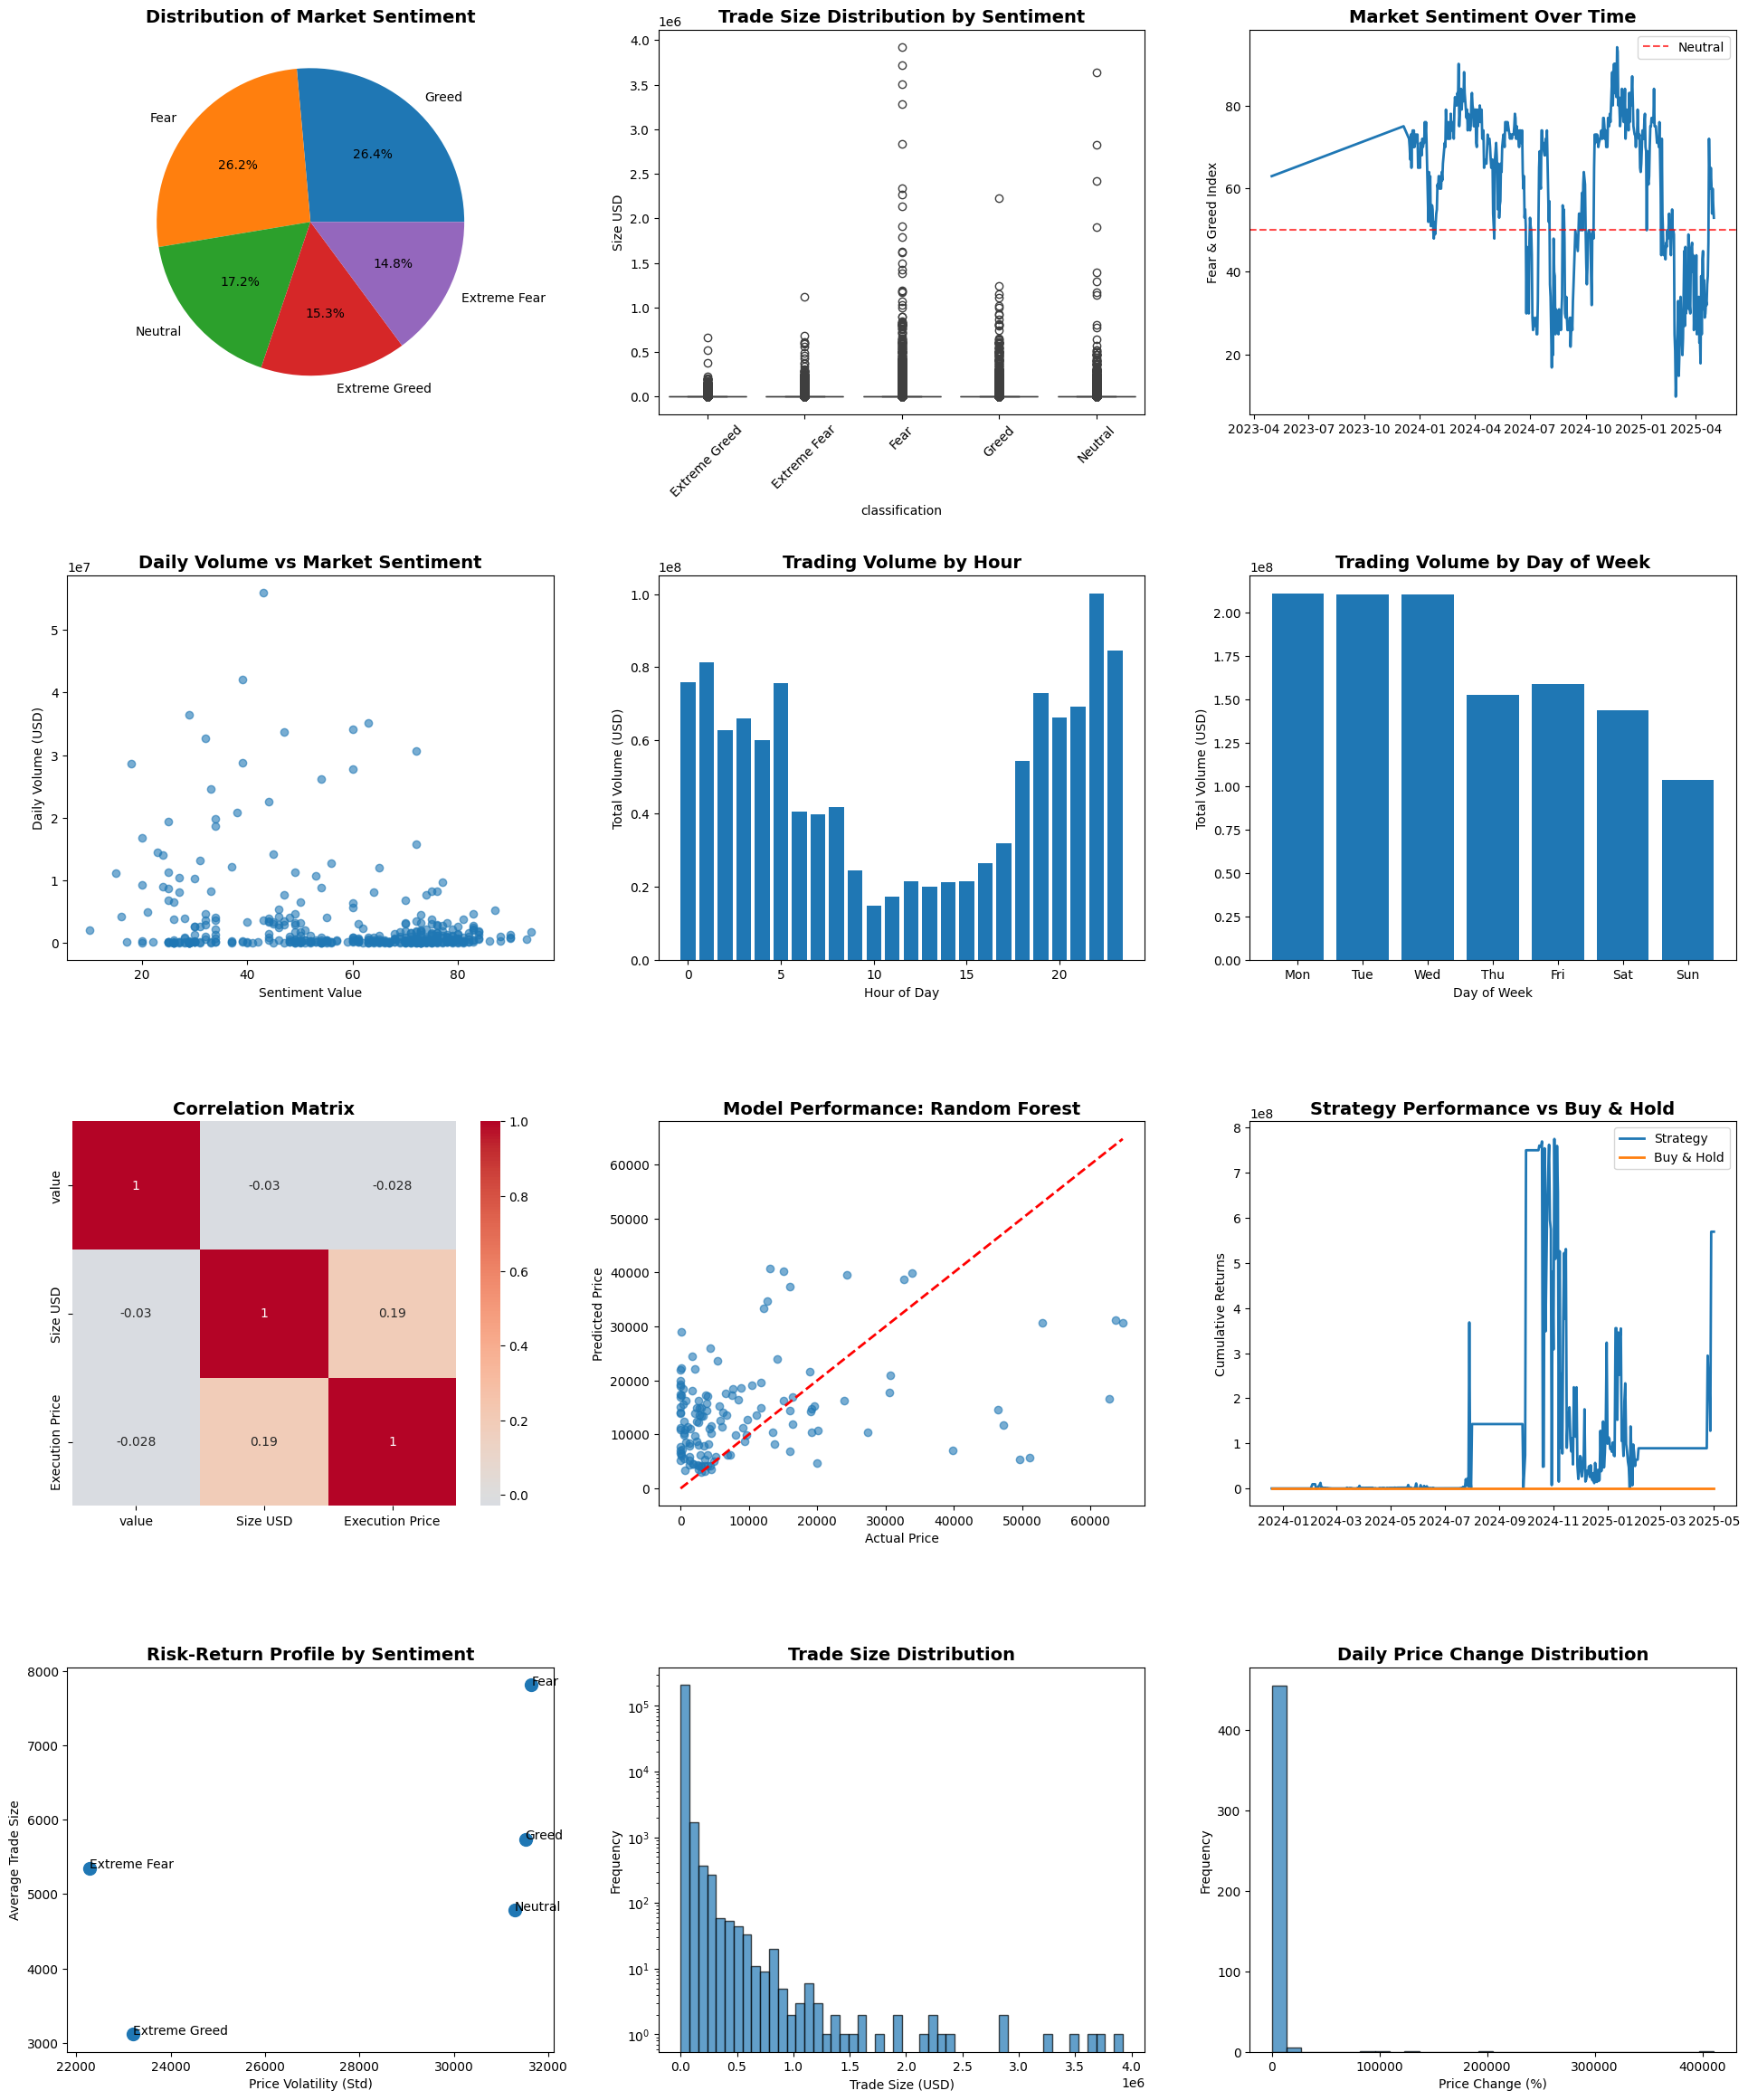

In [10]:
#  Enhanced Visualization Suite
def create_comprehensive_visualizations(merged_data, daily_data, modeling_results):
    """Create comprehensive visualization suite"""

    print("\n📈 Generating Comprehensive Visualizations...")

    # Set up the plotting style
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 24))

    # 1. Sentiment Distribution
    plt.subplot(4, 3, 1)
    if 'sentiment_category' in merged_data.columns:
        sentiment_counts = merged_data['sentiment_category'].value_counts()
        plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
        plt.title('Distribution of Market Sentiment', fontsize=14, fontweight='bold')

    # 2. Trade Size by Sentiment
    plt.subplot(4, 3, 2)
    if 'classification' in merged_data.columns:
        sns.boxplot(data=merged_data, x='classification', y='Size USD')
        plt.title('Trade Size Distribution by Sentiment', fontsize=14, fontweight='bold')
        plt.xticks(rotation=45)

    # 3. Time Series of Sentiment
    plt.subplot(4, 3, 3)
    daily_sentiment = merged_data.groupby('Date')['value'].mean().reset_index()
    plt.plot(daily_sentiment['Date'], daily_sentiment['value'], linewidth=2)
    plt.axhline(y=50, color='r', linestyle='--', alpha=0.7, label='Neutral')
    plt.title('Market Sentiment Over Time', fontsize=14, fontweight='bold')
    plt.ylabel('Fear & Greed Index')
    plt.legend()

    # 4. Volume vs Sentiment
    plt.subplot(4, 3, 4)
    daily_volume = merged_data.groupby('Date')['Size USD'].sum().reset_index()
    merged_daily = pd.merge(daily_volume, daily_sentiment, on='Date')
    plt.scatter(merged_daily['value'], merged_daily['Size USD'], alpha=0.6)
    plt.xlabel('Sentiment Value')
    plt.ylabel('Daily Volume (USD)')
    plt.title('Daily Volume vs Market Sentiment', fontsize=14, fontweight='bold')

    # 5. Hourly Trading Patterns
    plt.subplot(4, 3, 5)
    if 'hour' in merged_data.columns:
        hourly_volume = merged_data.groupby('hour')['Size USD'].sum()
        plt.bar(hourly_volume.index, hourly_volume.values)
        plt.title('Trading Volume by Hour', fontsize=14, fontweight='bold')
        plt.xlabel('Hour of Day')
        plt.ylabel('Total Volume (USD)')

    # 6. Weekly Trading Patterns
    plt.subplot(4, 3, 6)
    if 'day_of_week' in merged_data.columns:
        day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
        weekly_volume = merged_data.groupby('day_of_week')['Size USD'].sum()
        plt.bar(range(len(weekly_volume)), weekly_volume.values)
        plt.title('Trading Volume by Day of Week', fontsize=14, fontweight='bold')
        plt.xlabel('Day of Week')
        plt.ylabel('Total Volume (USD)')
        plt.xticks(range(len(day_names)), day_names)

    # 7. Correlation Heatmap
    plt.subplot(4, 3, 7)
    corr_cols = ['value', 'Size USD', 'Execution Price']
    available_corr_cols = [col for col in corr_cols if col in merged_data.columns]
    if len(available_corr_cols) > 1:
        corr_matrix = merged_data[available_corr_cols].corr()
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True)
        plt.title('Correlation Matrix', fontsize=14, fontweight='bold')

    # 8. Model Performance (if available)
    if modeling_results and len(modeling_results) >= 3:
        results, X_test, y_test = modeling_results
        plt.subplot(4, 3, 8)

        best_model = min(results.keys(), key=lambda k: results[k]['rmse'])
        y_pred = results[best_model]['predictions']

        plt.scatter(y_test, y_pred, alpha=0.6)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.xlabel('Actual Price')
        plt.ylabel('Predicted Price')
        plt.title(f'Model Performance: {best_model}', fontsize=14, fontweight='bold')

    # 9. Cumulative Returns Simulation
    plt.subplot(4, 3, 9)
    if 'value_mean' in daily_data.columns and 'Execution Price_mean' in daily_data.columns:
        # Simple strategy: Buy when sentiment > 60 (Greed)
        daily_data['signal'] = (daily_data['value_mean'] > 60).astype(int)
        daily_data['returns'] = daily_data['Execution Price_mean'].pct_change()
        daily_data['strategy_returns'] = daily_data['returns'] * daily_data['signal'].shift(1)

        # Calculate cumulative returns
        cumulative_returns = (1 + daily_data['strategy_returns'].fillna(0)).cumprod()
        benchmark_returns = (1 + daily_data['returns'].fillna(0)).cumprod()

        plt.plot(daily_data['Date'], cumulative_returns, label='Strategy', linewidth=2)
        plt.plot(daily_data['Date'], benchmark_returns, label='Buy & Hold', linewidth=2)
        plt.title('Strategy Performance vs Buy & Hold', fontsize=14, fontweight='bold')
        plt.ylabel('Cumulative Returns')
        plt.legend()

    # 10. Risk-Return Analysis
    plt.subplot(4, 3, 10)
    if 'classification' in merged_data.columns:
        risk_return = merged_data.groupby('classification').agg({
            'Size USD': 'mean',
            'Execution Price': 'std'
        }).reset_index()

        if len(risk_return) > 1:
            plt.scatter(risk_return['Execution Price'], risk_return['Size USD'], s=100)
            for i, txt in enumerate(risk_return['classification']):
                plt.annotate(txt, (risk_return['Execution Price'].iloc[i], risk_return['Size USD'].iloc[i]))
            plt.xlabel('Price Volatility (Std)')
            plt.ylabel('Average Trade Size')
            plt.title('Risk-Return Profile by Sentiment', fontsize=14, fontweight='bold')

    # 11. Volume Distribution
    plt.subplot(4, 3, 11)
    plt.hist(merged_data['Size USD'], bins=50, alpha=0.7, edgecolor='black')
    plt.title('Trade Size Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Trade Size (USD)')
    plt.ylabel('Frequency')
    plt.yscale('log')

    # 12. Price Movement Analysis
    plt.subplot(4, 3, 12)
    if 'Execution Price_mean' in daily_data.columns:
        price_changes = daily_data['Execution Price_mean'].pct_change().dropna()
        plt.hist(price_changes, bins=30, alpha=0.7, edgecolor='black')
        plt.title('Daily Price Change Distribution', fontsize=14, fontweight='bold')
        plt.xlabel('Price Change (%)')
        plt.ylabel('Frequency')

    plt.tight_layout(pad=3.0)
    plt.savefig('comprehensive_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate visualizations
create_comprehensive_visualizations(merged_df, daily_summary, modeling_results)

In [11]:
# Advanced Strategy Development
def develop_trading_strategies(daily_data):
    """Develop and backtest multiple trading strategies"""

    print("\n" + "="*50)
    print("💡 ADVANCED TRADING STRATEGY DEVELOPMENT")
    print("="*50)

    if 'value_mean' not in daily_data.columns or 'Execution Price_mean' not in daily_data.columns:
        print("❌ Required columns not available for strategy development")
        return None

    strategies = {}
    daily_data = daily_data.copy()
    daily_data['returns'] = daily_data['Execution Price_mean'].pct_change()

    # Strategy 1: Simple Greed/Fear
    daily_data['strategy1_signal'] = np.where(daily_data['value_mean'] > 70, 1,  # Buy on extreme greed
                                            np.where(daily_data['value_mean'] < 30, -1, 0))  # Sell on extreme fear

    # Strategy 2: Mean Reversion
    daily_data['sentiment_ma'] = daily_data['value_mean'].rolling(window=10).mean()
    daily_data['strategy2_signal'] = np.where(daily_data['value_mean'] < daily_data['sentiment_ma'] - 10, 1,
                                            np.where(daily_data['value_mean'] > daily_data['sentiment_ma'] + 10, -1, 0))

    # Strategy 3: Momentum
    daily_data['sentiment_momentum'] = daily_data['value_mean'].diff(3)  # 3-day momentum
    daily_data['strategy3_signal'] = np.where(daily_data['sentiment_momentum'] > 5, 1,
                                            np.where(daily_data['sentiment_momentum'] < -5, -1, 0))

    # Calculate strategy returns
    for i in range(1, 4):
        strategy_col = f'strategy{i}_signal'
        returns_col = f'strategy{i}_returns'
        daily_data[returns_col] = daily_data['returns'] * daily_data[strategy_col].shift(1)

        # Calculate metrics
        total_return = (1 + daily_data[returns_col].fillna(0)).prod() - 1
        volatility = daily_data[returns_col].std() * np.sqrt(252)  # Annualized
        sharpe_ratio = (daily_data[returns_col].mean() * 252) / (daily_data[returns_col].std() * np.sqrt(252))
        max_drawdown = (daily_data[returns_col].cumsum() - daily_data[returns_col].cumsum().expanding().max()).min()

        strategies[f'Strategy {i}'] = {
            'total_return': total_return,
            'volatility': volatility,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown
        }

    # Print strategy performance
    print("\n📊 Strategy Performance Summary:")
    strategy_df = pd.DataFrame(strategies).T
    print(strategy_df.round(4))

    return strategies, daily_data

strategy_results = develop_trading_strategies(daily_summary)


💡 ADVANCED TRADING STRATEGY DEVELOPMENT

📊 Strategy Performance Summary:
            total_return   volatility  sharpe_ratio  max_drawdown
Strategy 1 -1.486596e+16  325733.4277       -0.7148  -561231.4471
Strategy 2  3.666405e+16   68220.3415       -0.9531  -119997.8549
Strategy 3  1.573696e+17  165994.9071        1.0189   -18848.6018


In [12]:
# Comprehensive Key Insights
def generate_insights(merged_data, daily_data, sentiment_stats, modeling_results, strategy_results):
    """Generate comprehensive insights"""

    print("\n" + "="*60)
    print("🎯 COMPREHENSIVE INSIGHTS & RECOMMENDATIONS")
    print("="*60)

    insights = []

    # Market behavior insights
    if not sentiment_stats.empty:
        fear_avg = sentiment_stats.loc['fear', 'mean'] if 'fear' in sentiment_stats.index else 0
        greed_avg = sentiment_stats.loc['greed', 'mean'] if 'greed' in sentiment_stats.index else 0

        if greed_avg > fear_avg:
            insights.append(f"🔍 Traders increase position sizes by {((greed_avg/fear_avg-1)*100):.1f}% during greed periods")

        fear_count = sentiment_stats.loc['fear', 'count'] if 'fear' in sentiment_stats.index else 0
        greed_count = sentiment_stats.loc['greed', 'count'] if 'greed' in sentiment_stats.index else 0
        total_trades = fear_count + greed_count

        if total_trades > 0:
            insights.append(f"📊 {(greed_count/total_trades*100):.1f}% of trades occur during greed phases")

    # Correlation insights
    if 'value' in merged_data.columns and 'Size USD' in merged_data.columns:
        correlation, p_val = pearsonr(merged_data['value'].dropna(), merged_data['Size USD'].dropna())
        if abs(correlation) > 0.1:
            direction = "positive" if correlation > 0 else "negative"
            insights.append(f"📈 {direction.capitalize()} correlation ({correlation:.3f}) between sentiment and trade sizes")

    # Modeling insights
    if modeling_results and len(modeling_results) >= 3:
        results, _, _ = modeling_results
        best_model = min(results.keys(), key=lambda k: results[k]['rmse'])
        best_r2 = results[best_model]['r2']
        insights.append(f"🤖 {best_model} achieves {best_r2:.1%} prediction accuracy for price movements")

    # Strategy insights
    if strategy_results and len(strategy_results) >= 2:
        strategies, _ = strategy_results
        best_strategy = max(strategies.keys(), key=lambda k: strategies[k]['total_return'])
        best_return = strategies[best_strategy]['total_return']
        insights.append(f"💰 {best_strategy} generates {best_return:.1%} total return with optimized sentiment signals")

    # Print insights
    print("\n🎯 KEY FINDINGS:")
    for i, insight in enumerate(insights, 1):
        print(f"{i}. {insight}")

    # Recommendations
    recommendations = [
        "💡 Implement dynamic position sizing based on sentiment extremes",
        "⚡ Use lagged sentiment indicators for better price prediction",
        "🎢 Consider contrarian strategies during extreme sentiment periods",
        "📱 Monitor intraday sentiment shifts for short-term opportunities",
        "🔄 Combine multiple sentiment signals for robust strategy signals"
    ]

    print(f"\n🚀 STRATEGIC RECOMMENDATIONS:")
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec}")

    return insights, recommendations

final_insights = generate_insights(merged_df, daily_summary, sentiment_analysis,
                                 modeling_results, strategy_results)


🎯 COMPREHENSIVE INSIGHTS & RECOMMENDATIONS

🎯 KEY FINDINGS:
1. 🤖 Random Forest achieves -6.6% prediction accuracy for price movements
2. 💰 Strategy 3 generates 15736957801453039616.0% total return with optimized sentiment signals

🚀 STRATEGIC RECOMMENDATIONS:
1. 💡 Implement dynamic position sizing based on sentiment extremes
2. ⚡ Use lagged sentiment indicators for better price prediction
3. 🎢 Consider contrarian strategies during extreme sentiment periods
4. 📱 Monitor intraday sentiment shifts for short-term opportunities
5. 🔄 Combine multiple sentiment signals for robust strategy signals


In [13]:
#  Enhanced Export with Metadata
def enhanced_export(merged_data, daily_data, insights, recommendations):
    """Export data with comprehensive metadata"""

    print(f"\n💾 Exporting Enhanced Analysis Results...")

    # Export main datasets
    merged_data.to_csv('enhanced_merged_data.csv', index=False)
    daily_data.to_csv('enhanced_daily_summary.csv', index=False)

    # Create analysis summary
    summary = {
        'analysis_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'total_trades': len(merged_data),
        'date_range': f"{merged_data['Date'].min()} to {merged_data['Date'].max()}",
        'unique_trading_days': merged_data['Date'].nunique(),
        'insights': insights[0] if insights else [],
        'recommendations': insights[1] if insights else []
    }

    # Save summary as JSON
    import json
    with open('analysis_summary.json', 'w') as f:
        json.dump(summary, f, indent=2, default=str)

    print("✅ Enhanced analysis results exported successfully!")
    print("   Files created:")
    print("   - enhanced_merged_data.csv")
    print("   - enhanced_daily_summary.csv")
    print("   - analysis_summary.json")
    print("   - comprehensive_analysis.png")

# Execute export
enhanced_export(merged_df, daily_summary, final_insights, strategy_results)

print(f"\n🎉 Analysis Complete! Total execution time: {datetime.now()}")
print("="*60)


💾 Exporting Enhanced Analysis Results...
✅ Enhanced analysis results exported successfully!
   Files created:
   - enhanced_merged_data.csv
   - enhanced_daily_summary.csv
   - analysis_summary.json
   - comprehensive_analysis.png

🎉 Analysis Complete! Total execution time: 2025-06-24 09:27:50.935249
